In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

#from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
from tqdm import tqdm_notebook
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### **Data**

In [14]:
class EEGDataset(Dataset):
    def __init__(self, inputs, labels, num_classes=None):
        self.x_train = np.expand_dims(inputs, axis=1)
        self.y_train = labels
        self.num_classes = num_classes

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        x = self.x_train[idx]
        y = self.y_train[idx]
        if self.num_classes: y = F.one_hot(y, num_classes=self.num_classes).float()

        return x, y
    
X = torch.load('/home/mairj/Projects/GenModels/projetos/EEGen/notebooks/data/processed/X.pt')
y = torch.load('/home/mairj/Projects/GenModels/projetos/EEGen/notebooks/data/processed/y.pt')

#preprocessing --- NORMALIZATION
X_np = X.numpy()

# Reshape the data if necessary (StandardScaler expects 2D array)
X_np_reshaped = X_np.reshape(X_np.shape[0], -1)

# Create and fit the StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_np_reshaped)

# Convert back to PyTorch tensor if needed
X_normalized_tensor = torch.from_numpy(X_normalized.reshape(X_np.shape))

#datasets
BATCH_SIZE = 32
N_CLASSES = 4

dataset = EEGDataset(X_normalized_tensor, y, num_classes=N_CLASSES)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for i, (dt, lbl) in enumerate(dataloader):
    if i==0: print(dt.shape, lbl.shape, dt.min(), dt.max())
print(i, dt.shape, lbl.shape)

torch.Size([32, 1, 22, 450]) torch.Size([32, 4]) tensor(-7.4247) tensor(5.8257)
17 torch.Size([32, 1, 22, 450]) torch.Size([32, 4])


### **Model**

In [15]:
from torch.optim.lr_scheduler import ExponentialLR, StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

In [16]:
class Generator(nn.Module):
    def __init__(self, noise_dim, signal_dim, hidden_dim, num_layers, class_dim, batch_size):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.signal_dim = signal_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.class_dim = class_dim
        self.batch_size = batch_size

        self.lstm = nn.LSTM(noise_dim + class_dim, hidden_dim, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, signal_dim)
        self.fc1 = nn.Linear(hidden_dim, signal_dim * 22)
        #self.fc2 = nn.Linear(signal_dim * 22, signal_dim)

    def forward(self, z, c):
        #print("z", z.shape)
        #print("c", c.shape)
        zc = torch.cat([z, c], dim=1).unsqueeze(1) #.permute(1, 0, 2)
        #print("zc", zc.shape)
        h0 = torch.zeros(self.num_layers, z.size(0), self.hidden_dim).to(device)
        #print("h0", h0.shape)
        c0 = torch.zeros(self.num_layers, z.size(0), self.hidden_dim).to(device)
        output, _ = self.lstm(zc, (h0, c0))
        #print("c0", c0.shape)
        output = self.fc1(output)
        
        #print("output", output.shape)
        # Reshape the output tensor
        #batch_size, _, _ = output.size()
        output = output.view(self.batch_size, 1, 22, self.signal_dim)
        #print("output", output.shape)
        return output

In [17]:
class Discriminator(nn.Module):
    def __init__(self, signal_dim, hidden_dim, num_layers, class_dim):
        super(Discriminator, self).__init__()
        self.signal_dim = signal_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.class_dim = class_dim

        self.lstm = nn.LSTM(22*signal_dim + class_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, c):
        #print("x", x.shape, x.dtype)
        #print("c", c.shape, c.double().dtype)
        xc = torch.cat([x, c.double()], dim=1).permute(0, 2, 1) #.unsqueeze(1)
        #print("xc", xc.shape, xc.dtype)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, dtype=torch.float64).to(x.device)
        #print("h0", h0.shape, h0.dtype)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, dtype=torch.float64).to(x.device)
        #print("c0", c0.shape, c0.dtype)
        output, _ = self.lstm(xc, (h0, c0))
        #print("output", output.shape)

        output = self.fc(output)
        #print("output", output.shape)
        output = torch.sigmoid(output.squeeze(1))
        #print("output", output.shape)
        return output

### **Trainer**

In [20]:
def train(generator, discriminator, dataloader, num_epochs, noise_dim, num_classes, d_optim, g_optim, criterion, gen_scheduler, disc_scheduler):
    discr_losses = []
    gener_losses = []

    # TRAIN TESTER

    for epoch in range(num_epochs):
        for i_batch, (dataloader_data, dataloader_label) in enumerate(dataloader):
            
            real_signals = dataloader_data.to(device) #[BATCH_SIZE, 1, 22, TEMPORAL_LENGHT]
            class_labels = dataloader_label.to(device) #[BATCH_SIZE, N_CLASSES]
            #print("DATALOADER_DATA:", real_signals.shape, "DATALOADER_LABEL:", class_labels.shape)
            
            d_optim.zero_grad()
            
            noise = torch.randn(dataloader_data.size(0), noise_dim).to(device) #[BATCH_SIZE, NOISE_DIM]
            fake_signals = generator(noise, class_labels)
            #print("NOISE:", noise.shape, "FAKE_DATA:", fake_signals.shape)

            disc_hot_labels = class_labels[:, :, None, None].view(dataloader_data.size(0), num_classes, 1)
            disc_fake_signals = fake_signals.view(dataloader_data.size(0), -1, 1)
            disc_real_signals = real_signals.view(dataloader_data.size(0), -1, 1)
            disc_fake_out = discriminator(disc_fake_signals, disc_hot_labels)
            disc_real_out = discriminator(disc_real_signals, disc_hot_labels)
            disc_fake_loss = criterion(disc_fake_out.detach(), torch.zeros(dataloader_data.size(0)).unsqueeze(1).to(device))
            disc_real_loss = criterion(disc_real_out, torch.zeros(dataloader_data.size(0)).unsqueeze(1).to(device))
            disc_loss = (disc_real_loss + disc_fake_loss) / 2
            disc_loss.backward(retain_graph=True)
            d_optim.step()
            #print("FAKE_DATA_IN_DISC:", disc_fake_signals.shape, "FAKE_LABEL_IN_DISC:", disc_hot_labels.shape)
            #print("FAKE_OUT_DISC:", disc_fake_out.shape, "REAL_OUT_DISC:", disc_real_out.shape)
            #print("DISC_JOINT_LOSS:", disc_loss.item(), "DISC_REAL_LOSS:", disc_real_loss.item(), "DISC_FAKE_LOSS:", disc_fake_loss.item())

            discr_losses += [disc_loss.item()]

            g_optim.zero_grad()
            disc_fake_out = discriminator(disc_fake_signals, disc_hot_labels)
            gen_loss = criterion(disc_fake_out, torch.ones(dataloader_data.size(0)).unsqueeze(1).to(device))
            gen_loss.backward()
            g_optim.step()
            #print("GEN_LOSS:", gen_loss.item())

            gener_losses += [gen_loss.item()]
        gen_scheduler.step()
        disc_scheduler.step()

        print('Epoch [{}/{}], generator_loss: {}, discriminator_loss: {}'.format(epoch, num_epochs, gen_loss, disc_loss))
    
    return gener_losses, discr_losses

In [ ]:
#### PARAMS ####  
BATCH_SIZE = 32 
NOISE_DIM = 100
N_CLASSES = 4
SIGNAL_DIM = 375
HIDDEN_DIM = 64
NUM_LAYERS = 2
CHANNELS = 1

#### GENERATOR ####  
noise = torch.randn(BATCH_SIZE, NOISE_DIM).to(device)
fake_labels = torch.FloatTensor(np.eye(N_CLASSES)[np.random.randint(0, N_CLASSES, BATCH_SIZE)]).to(device)
print(noise.shape, fake_labels.shape)
generator = Generator(NOISE_DIM, SIGNAL_DIM, HIDDEN_DIM, NUM_LAYERS, N_CLASSES, BATCH_SIZE, CHANNELS).to(device)
fake_signals = generator(noise, fake_labels)
print(fake_signals.shape)

#### DISCRIMINATOR ####  
noise = torch.randn(BATCH_SIZE, NOISE_DIM).to(device)
fake_labels = torch.FloatTensor(np.eye(N_CLASSES)[np.random.randint(0, N_CLASSES, BATCH_SIZE)]).to(device)
print(noise.shape, fake_labels.shape)
generator = Generator(NOISE_DIM, SIGNAL_DIM, HIDDEN_DIM, NUM_LAYERS, N_CLASSES, BATCH_SIZE, CHANNELS).to(device)
fake_signals = generator(noise, fake_labels)
fake_signals.shape

In [21]:
BATCH_SIZE = BATCH_SIZE #signal.size(0) para incluir o ultimo batch do dataloader que eh descompensado
NOISE_DIM = 100
N_CLASSES = N_CLASSES
SIGNAL_DIM = 450
HIDDEN_DIM = 64
NUM_LAYERS = 2
N_EPOCHS = 100

generator = Generator(NOISE_DIM, SIGNAL_DIM, HIDDEN_DIM, NUM_LAYERS, N_CLASSES, BATCH_SIZE).to(device)
discriminator = Discriminator(SIGNAL_DIM, HIDDEN_DIM, NUM_LAYERS, N_CLASSES).to(device)

g_optim = optim.Adam(generator.parameters(), lr=5e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=1e-4)

criterion = nn.BCELoss()

gen_scheduler = ExponentialLR(g_optim, gamma=0.5)
disc_scheduler = ExponentialLR(d_optim, gamma=0.5)
#disc_scheduler = StepLR(d_optim, gamma=0.6, step_size=15) #d_optim, gamma=0.6, step_size=15
#gen_scheduler = StepLR(g_optim, gamma=0.6, step_size=15) #g_optim, gamma=0.6, step_size=10


In [22]:
generenator_losses, discriminator_losses = train(generator, discriminator, dataloader, N_EPOCHS, NOISE_DIM, N_CLASSES, d_optim, g_optim, criterion, gen_scheduler, disc_scheduler)

Epoch [0/100], generator_loss: 0.5937836260179349, discriminator_loss: 0.7619547604834518
Epoch [1/100], generator_loss: 0.5619472280618817, discriminator_loss: 0.775824069783748
Epoch [2/100], generator_loss: 0.5468035382019695, discriminator_loss: 0.7837456163362442
Epoch [3/100], generator_loss: 0.5410064088214821, discriminator_loss: 0.7878505098150144
Epoch [4/100], generator_loss: 0.5373623386674544, discriminator_loss: 0.7892744952688158
Epoch [5/100], generator_loss: 0.5358880196350821, discriminator_loss: 0.7898720920678155
Epoch [6/100], generator_loss: 0.5349934957567477, discriminator_loss: 0.7905552582684103
Epoch [7/100], generator_loss: 0.5349316483504019, discriminator_loss: 0.7905903838144434
Epoch [8/100], generator_loss: 0.5343315444302313, discriminator_loss: 0.7923524462229601
Epoch [9/100], generator_loss: 0.5350371875716416, discriminator_loss: 0.7890196250701531
Epoch [10/100], generator_loss: 0.5344081787178634, discriminator_loss: 0.7913000091741644
Epoch [11/

In [45]:
torch.save(generator, "/home/mairj/Projects/GenModels/projetos/EEGen/finalising/saves/lstm_gan_gen.pt")
torch.save(discriminator, "/home/mairj/Projects/GenModels/projetos/EEGen/finalising/saves/lstm_gan_disc.pt")

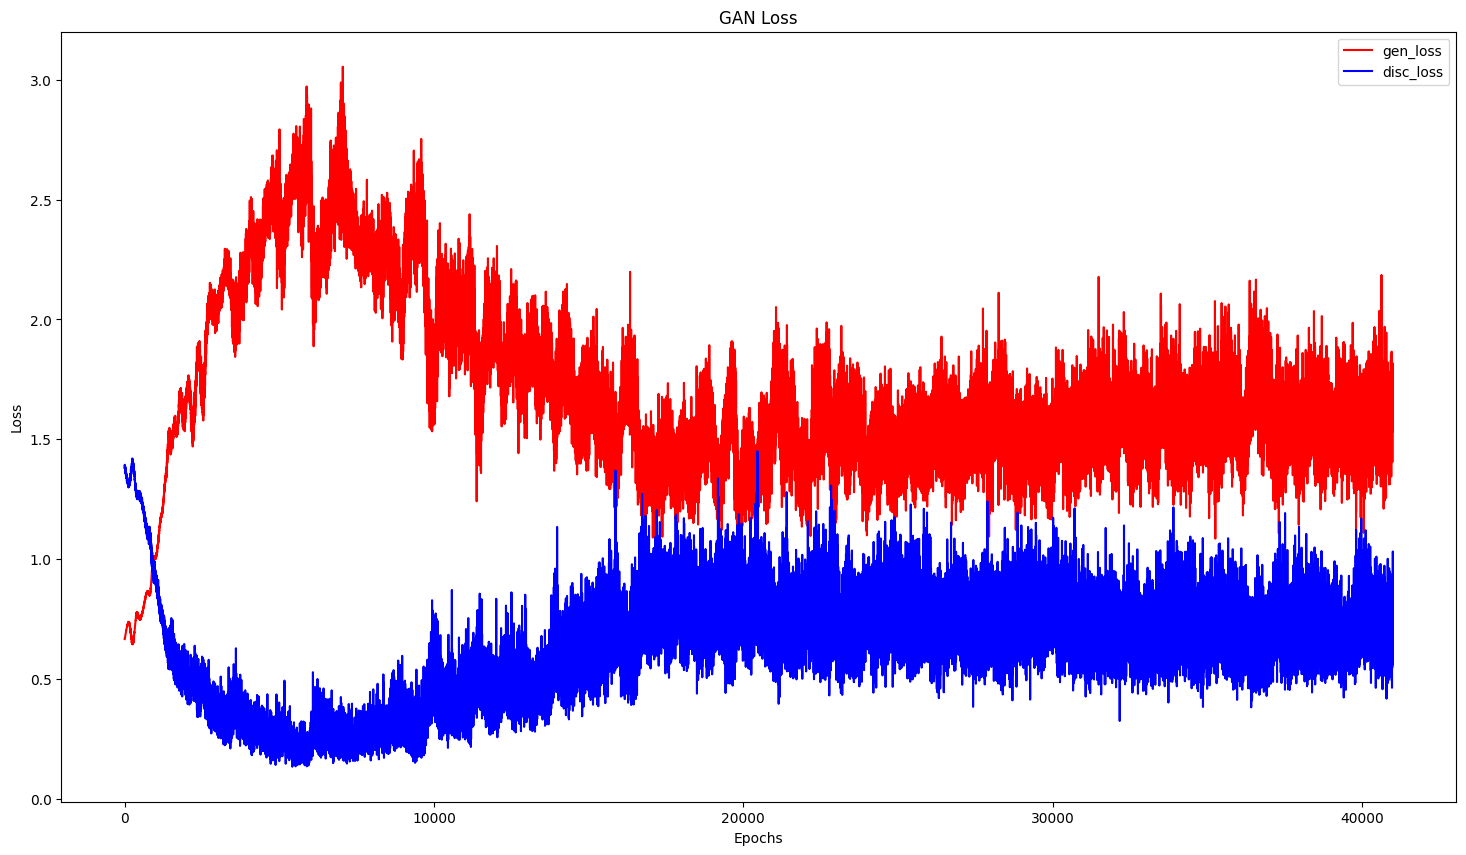

In [46]:
plt.figure(figsize=(18,10))
plt.plot(generator_losses, label = 'gen_loss', color = 'red')
plt.plot(discriminator_losses, label = 'disc_loss', color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Loss')
plt.legend()
plt.show()

### **Generating**

In [47]:
# original data
inputs.shape, inputs.min(), inputs.max()

((1296, 375), -1.0, 1.0)

In [ ]:
num_samples = 576*9
num_classes = 4
class_index = 3

# Generate random noise for each sample
noise = torch.randn(num_samples, NOISE_DIM).to(device)

# Generate random integers between 0 and num_classes-1
random_samples = torch.randint(0, num_samples, size=(num_samples,))

# Create an empty tensor with zeros
one_hot = torch.zeros(num_samples, num_classes)

# Set the value at the class_index to 1 for each sample in the same column
one_hot[torch.arange(num_samples), class_index] = 1

# Optionally, convert to float and move to the desired device
one_hot = one_hot.float().to(device)
print(one_hot)
signals = generator(noise, one_hot)

# Move the signals to the CPU, detach from the computation graph, and convert to NumPy
eeg = signals.cpu().detach().numpy()

# The shape of 'eeg' will be (num_samples, signal_dim), where 'signal_dim' is the dimensionality of your generated signals
print(eeg.shape)

In [69]:
#inputs_des = inputs * scaler.scale_ + scaler.mean_

# If you used scikit-learn's normalize
# inputs = inputs * max(abs(inputs), axis=1, keepdims=True)
#inputs_des *= np.max(np.abs(inputs_des), axis=1, keepdims=True)

In [68]:
#data.drop('label', axis=1)

In [86]:
#eeg_des = eeg * scaler.scale_ + scaler.mean_

# If you used scikit-learn's normalize
# inputs = inputs * max(abs(inputs), axis=1, keepdims=True)
#eeg_des *= np.max(np.abs(eeg_des), axis=1, keepdims=True)

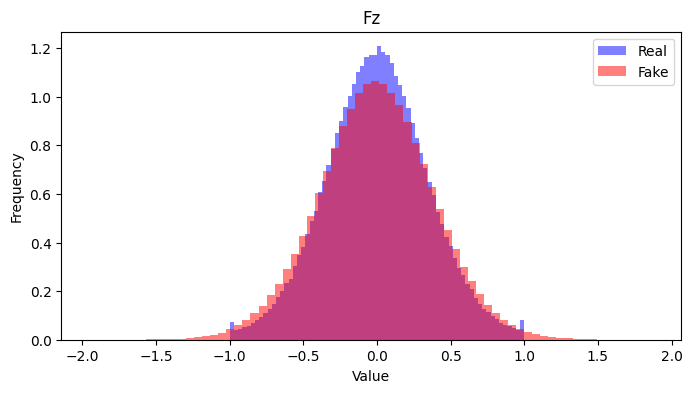

In [72]:
plt.figure(figsize=(8, 4))
plt.hist(inputs.flatten(), bins=70, color='blue', alpha=0.5, density=True, label='Real')
plt.hist(eeg.flatten(), bins=70, color='red', alpha=0.5, density=True, label='Fake')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Fz')
#plt.grid(True)
plt.legend()
plt.show()

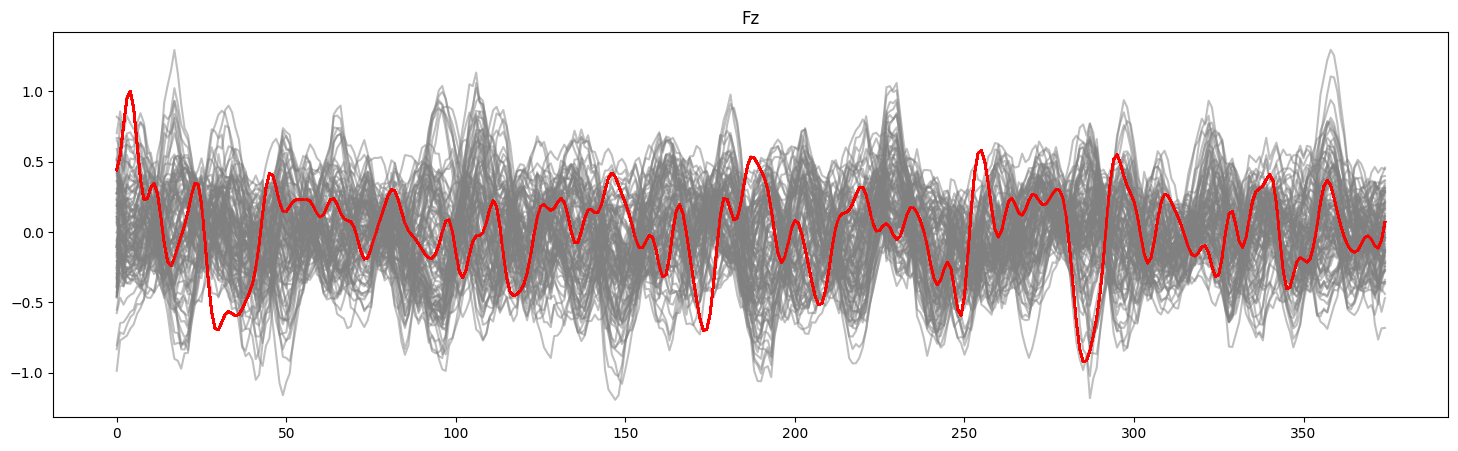

In [122]:
def moving_average(data, window_size):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean()

# Create a plot for each line in the array
plt.figure(figsize=(18,5))
for i in range(100):
    plt.plot(moving_average(eeg[i, :], 6), label=f'Line {i+1}', color='gray', alpha=0.5)
    plt.plot(inputs[0,:], color='red', alpha=0.9)

# Add labels and title
#plt.xlabel('X-axis')
#plt.ylabel('Y-axis')
plt.title('Fz')

# Add a legend
#plt.legend()

# Show the plot
plt.show()

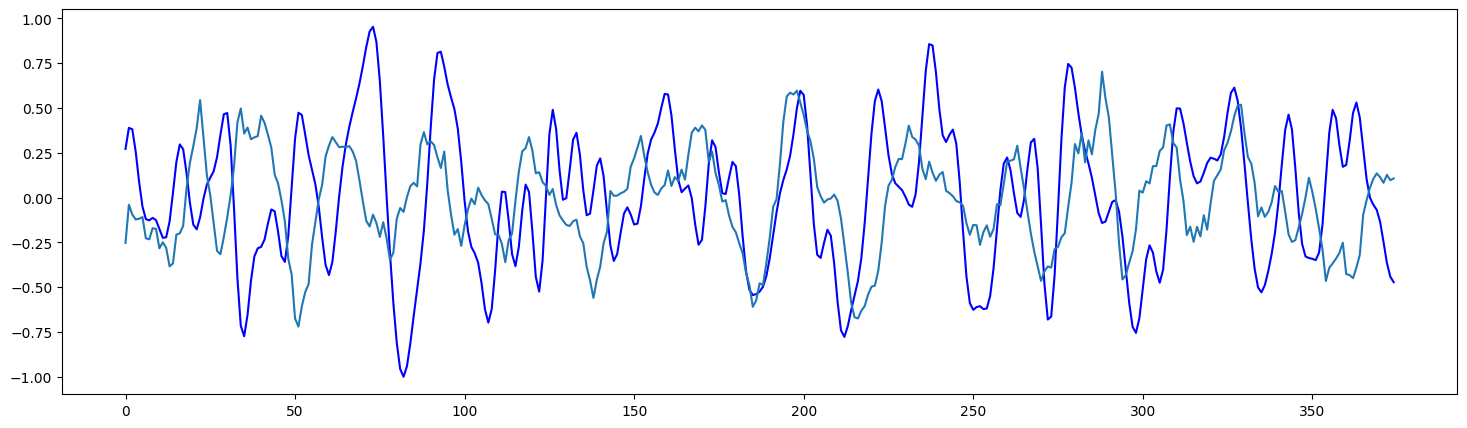

In [118]:
def moving_average(data, window_size):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(18,5))
#plt.plot(eeg[1, :], color='red', label='EEG')
plt.plot(inputs[1, :], color='blue', label='EEG')
plt.plot(moving_average(data=eeg[1, :], window_size=5))

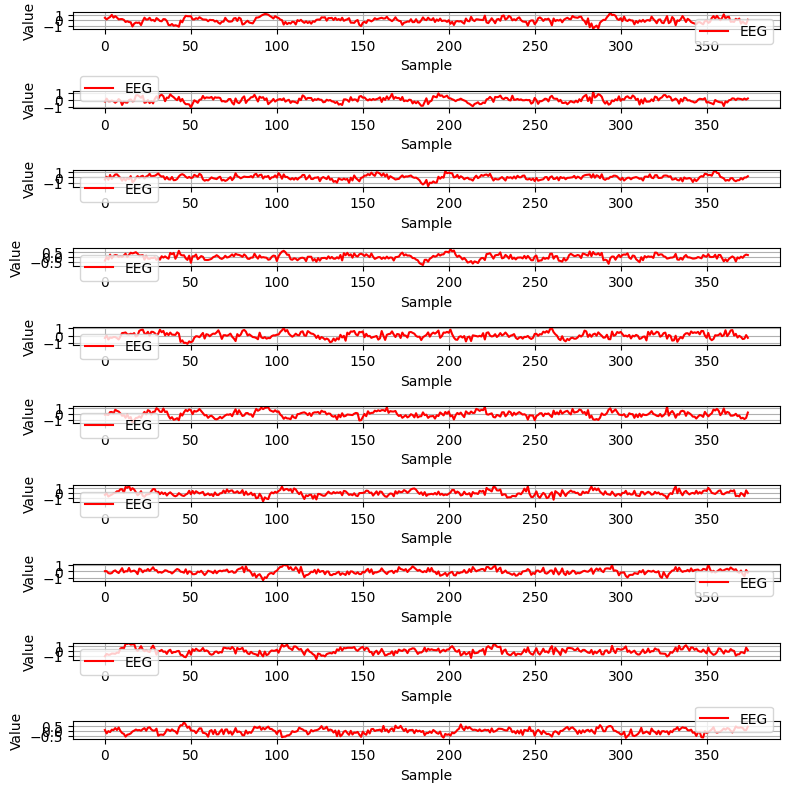

In [78]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(8, 8))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop over the subplots and plot both 'inputs' and 'eeg' on the same plot
for i in range(10):
    #axes[i].plot(inputs[i, :], color='blue', label='Inputs')
    axes[i].plot(eeg[i, :], color='red', label='EEG')
    
    axes[i].set_xlabel('Sample')
    axes[i].set_ylabel('Value')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()